In [1]:
import pandas as pd
from obspy.core import UTCDateTime
stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
color_list = []
stats = stats.groupby('Station').agg({'StartTime': 'min', 'EndTime': 'max','Latitude': 'first', 'Longitude': 'first', 'Elevation': 'first'}).reset_index()
for i,row in stats.iterrows():
    dt = UTCDateTime(row.EndTime)-UTCDateTime(row.StartTime) # in sec
    if dt < (60*60*24*30): # 30d in sec
        stats.drop(i, inplace=True)
     
    else:
        if UTCDateTime(row.EndTime)<UTCDateTime("2000-01-01"): # only 1980
            color_list.append('orange')

        elif UTCDateTime(row.StartTime)>UTCDateTime("2000-01-01"): # only 2004
            color_list.append('red')

        else:
            color_list.append('blue')
stats['color'] = color_list
stats = stats.reset_index(drop=True)
print(stats.shape)
stats.head()

(57, 7)


,Station,StartTime,EndTime,Latitude,Longitude,Elevation,color
0,APE,1980-03-23T00:00:00,1980-06-15T00:00:00,46.099461,-122.207497,579.0,orange
1,ASH,1981-05-13T00:00:00,1981-09-15T23:59:59,46.200668,-122.185471,1900.0,orange
2,B201,2007-09-12T00:00:00,2599-12-31T23:59:59,46.303299,-122.264801,990.0,red
3,B202,2007-07-25T00:00:00,2599-12-31T23:59:59,46.244701,-122.136703,1218.6,red
4,B203,2007-07-18T00:00:00,2599-12-31T23:59:59,46.168999,-122.333664,814.4,red


grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -122.407552 to -122.408333333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -121.990962 to -121.990833333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 46.049461 to 46.0491666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.40067 to 46.4008333333


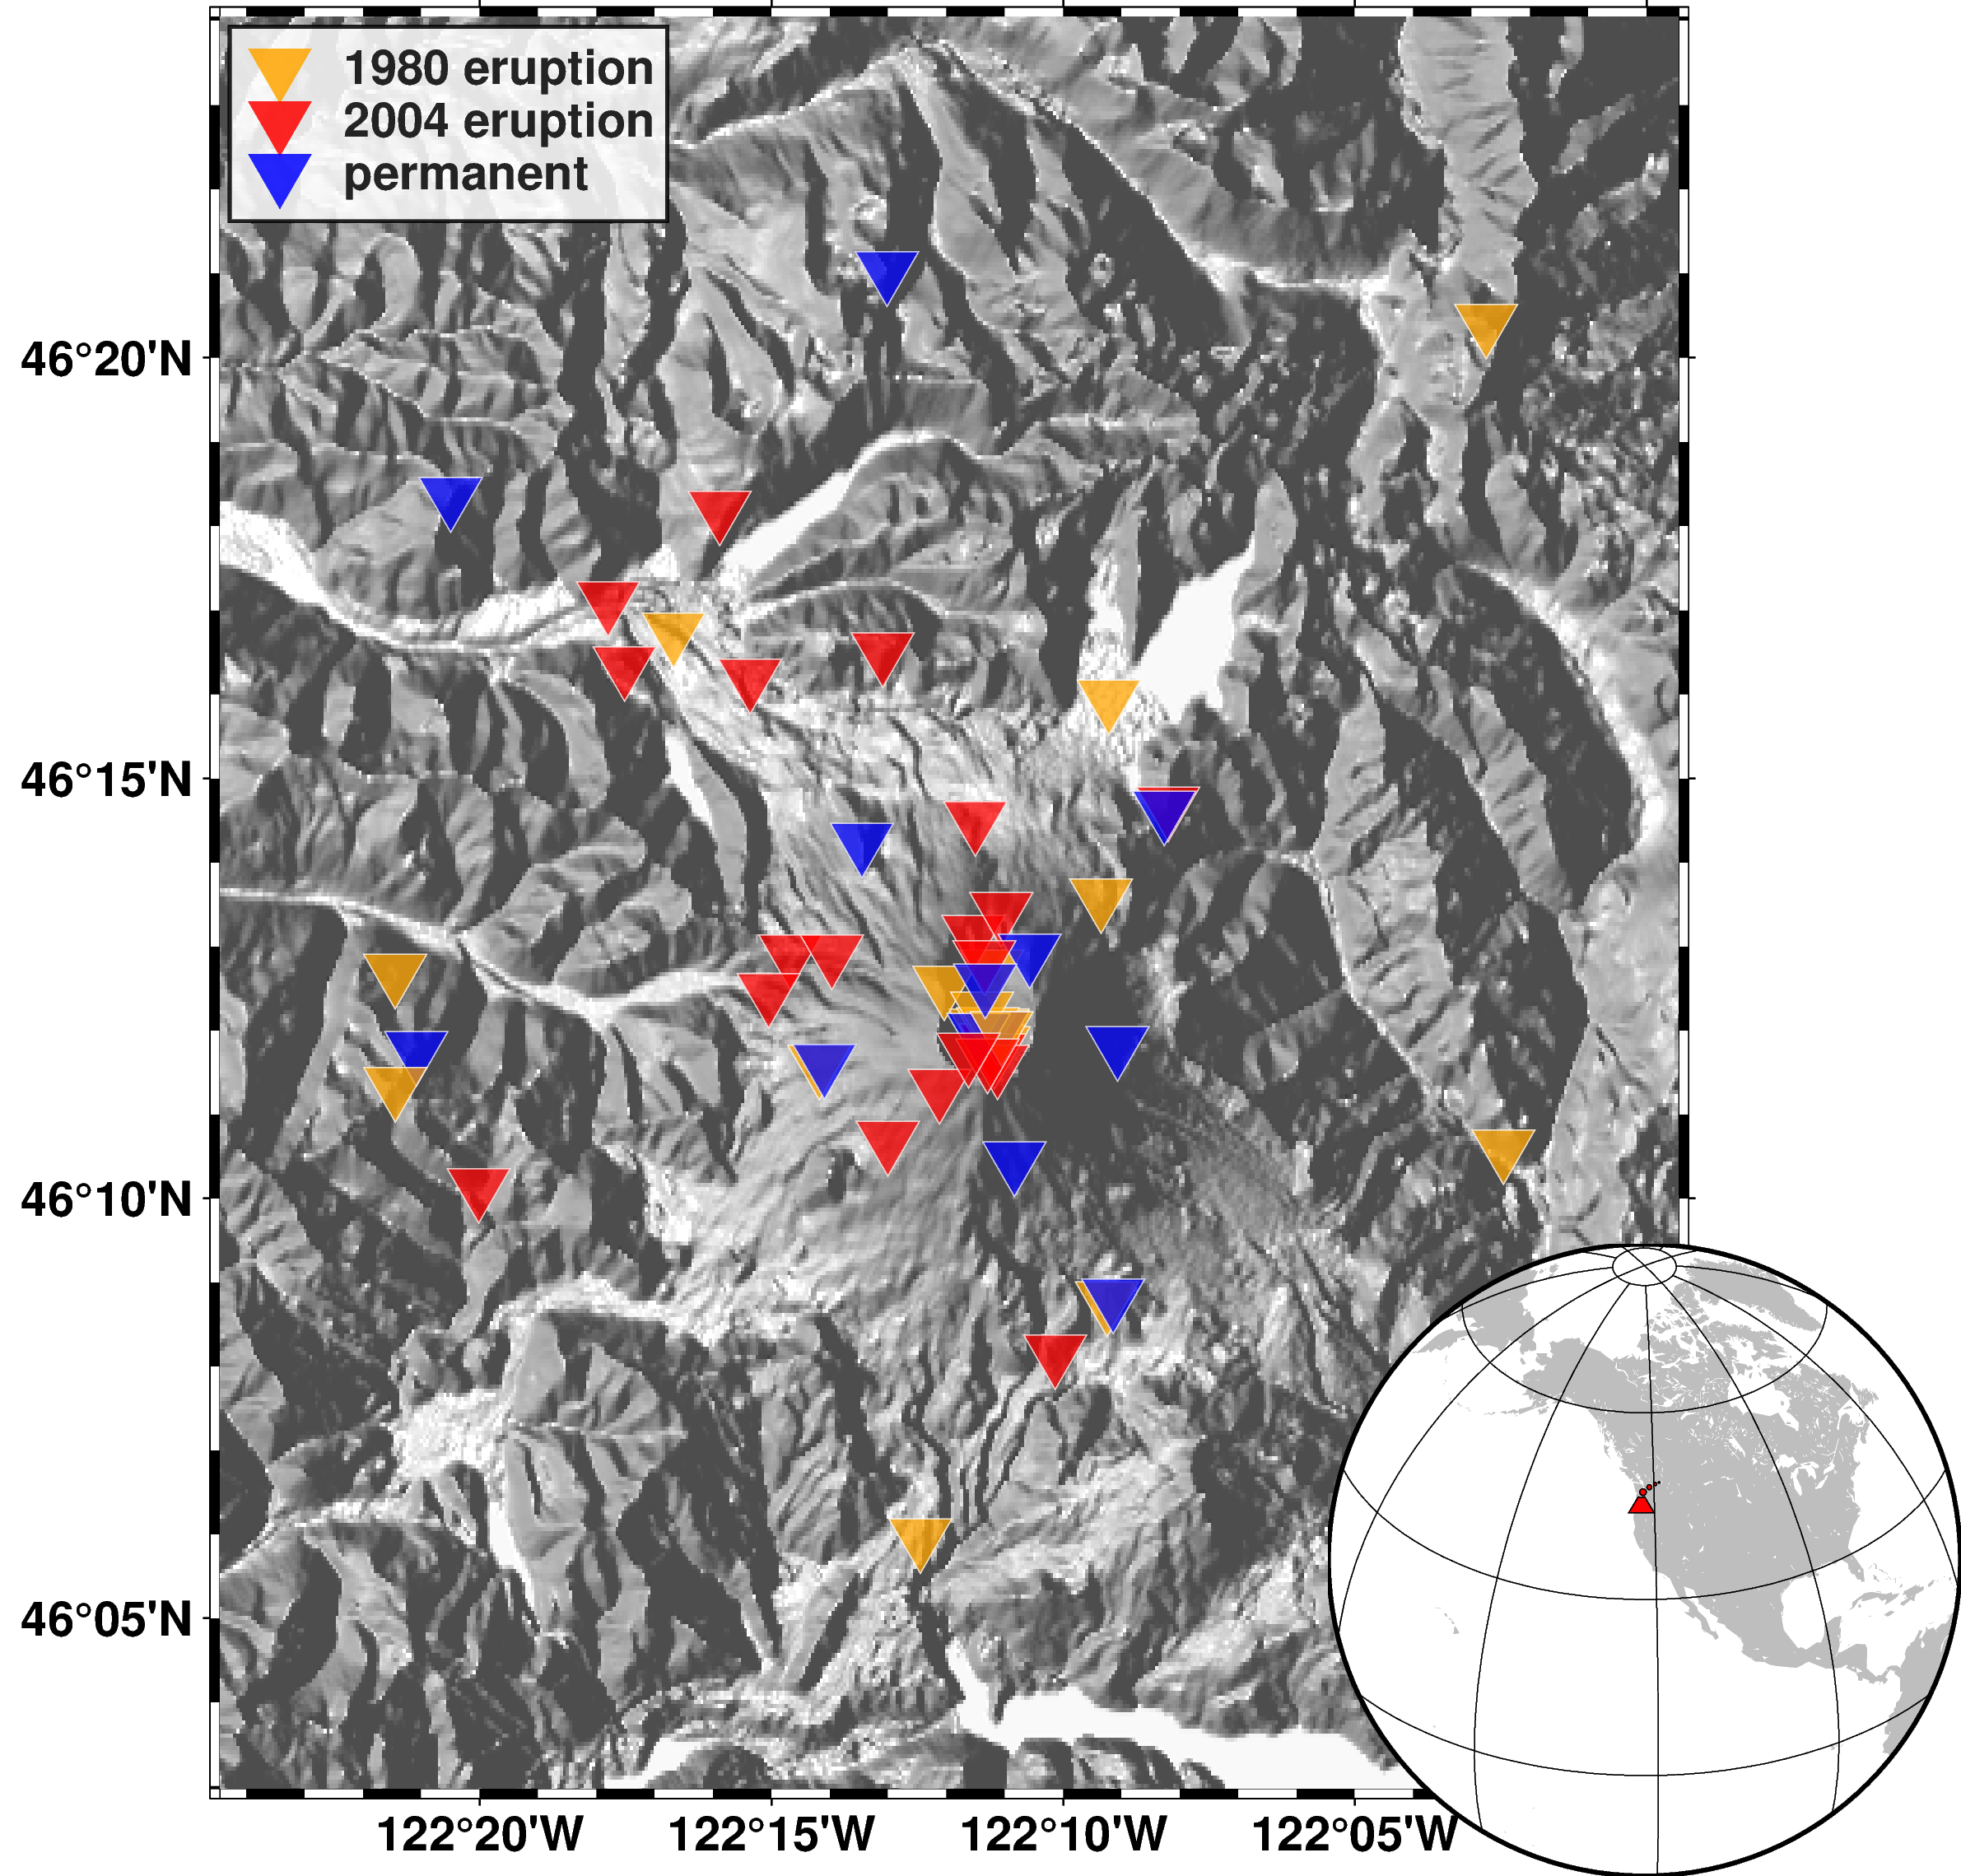

In [4]:
import numpy as np
import pygmt
import pandas as pd


# stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
# 2 is lat 3 is lon
region = [
    stats.Longitude.min() - .05,
    stats.Longitude.max() + .05,
    stats.Latitude.min() - .05,
    stats.Latitude.max() + .05,
]

helen = (46.191, -122.196)



pygmt.config(FONT='14p,Helvetica-Bold')
pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig = pygmt.Figure()
# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution='03s', region=region)
# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

fig.basemap(region=region, projection="M15c", frame=True)
fig.grdimage(grid=dgrid, projection="M15c", cmap=True) #cmap="geo")

for i in stats.index:
    fig.plot(
        x=stats.Longitude[i], y=stats.Latitude[i], style="i0.75c",
        fill=stats.color[i],pen="white", transparency=25)
    
# legende
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill='orange', transparency=25,
    label='1980 eruption')
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill='red', transparency=25,
    label='2004 eruption')
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill='blue', transparency=25,
    label='permanent')

# fig.plot(
#     x=stats.Longitude[1], y=stats.Latitude[1], style="i0.9c", color="black",
#     pen="white", label=f'{stats.Network[1]}.{stats.Station[1]}')
# fig.plot(
#     x=stats.Longitude[2], y=stats.Latitude[2], style="i0.9c", color="magenta",
#     pen="white", label=f'{stats.Network[2]}.{stats.Station[2]}')
# fig.plot(
#     x=stats.Longitude[3], y=stats.Latitude[3], style="i0.9c", color="blue",
#     pen="white", label=f'{stats.Network[3]}.{stats.Station[3]}')
fig.legend(
    transparency=15, box="+gwhite+p1p", position="jTL+jTL+w4.5c/2.c+o0.1c")

# fig.plot(
#     x=helen[1], y=helen[0], style="kvolcano/1c", color="red", pen="white",
#     label='Volcanoes')

# fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"])

lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
    fig.coast(
        projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
        land="gray", water='white')
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.33c", fill="red",
        pen="black", projection=f"G{lonmid}/{latmid}/60/6.5c")

# fig.savefig('station_map_1980_2004_hillshade2.png', dpi=300, transparent=True)
fig.show()
